# Load libraries


In [24]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import weibull_min, norm, geom, uniform, lognorm
from scipy.linalg import solve

In [2]:
# Set the root directory to be able to access other folders in the project

CURR_DIR = os.getcwd()  # current working directory
BASE_DIR = Path(CURR_DIR).parent  # parent directory
print(BASE_DIR)

/home/adrien/Documents/Github/MFA/02_stock_driven_and_surv_curves/tutorial_and_homework


# Import data


In [3]:
# Load input data, inflow-driven model:
# and check your data

file_path = BASE_DIR / "data" / "raw" / "MFA_II_tutorial_II.xlsx"
data = pd.read_excel(file_path, sheet_name="stock_driven")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     61 non-null     int64  
 1   stock    61 non-null     int64  
 2   inflow   0 non-null      float64
 3   outflow  0 non-null      float64
dtypes: float64(2), int64(2)
memory usage: 2.0 KB


In [4]:
# set the index to year
data = data.set_index(["year"])

years = data.index
end_year = years[-1]
print(f"end_year = {end_year}")

data

end_year = 2050


,stock,inflow,outflow
year,,,
1990,20,NaN,NaN
1991,21,NaN,NaN
1992,30,NaN,NaN
1993,39,NaN,NaN
1994,45,NaN,NaN
...,...,...,...
2046,724,NaN,NaN
2047,737,NaN,NaN
2048,750,NaN,NaN


In [5]:
step_max = data.shape[0]
timesteps = np.arange(0, step_max)
timesteps

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

# Create a survival curve

(if one wasn't supplied as input data)


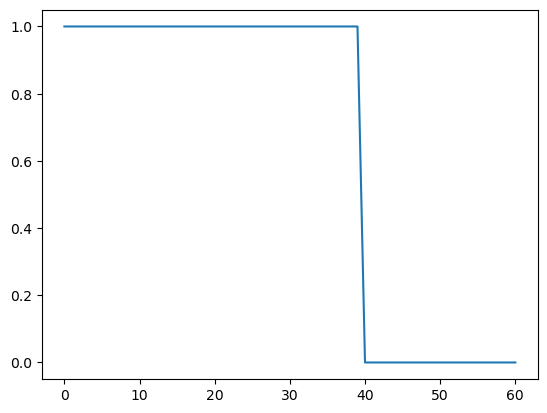

In [6]:
# Fixed lifetime survival curve

fixed_lifetime = 40
survival_curve = np.ones_like(timesteps)
survival_curve[fixed_lifetime:] = 0

plt.plot(survival_curve)
plt.show()

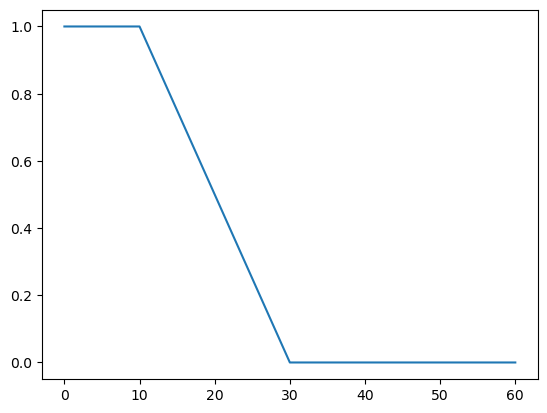

In [7]:
# Uniform distribution
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.uniform.html#scipy.stats.uniform

uniform_dist = uniform(
    loc=10,  # shifts the curve along the x-axis (starting point)
    scale=20,  # controls the width (ending point)
)
survival_curve = uniform_dist.sf(timesteps)  # sf = survival function
plt.plot(survival_curve)
plt.show()

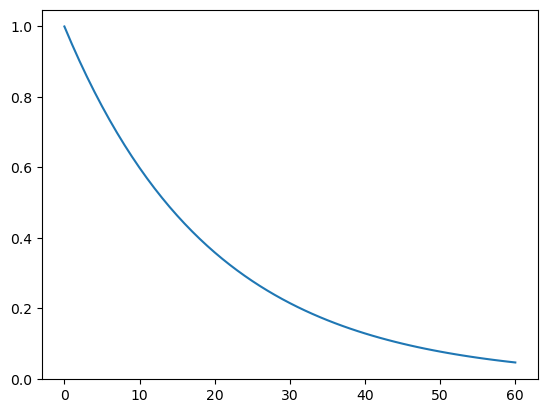

In [8]:
# Geometric distribution
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.geom.html#scipy.stats.geom

geom_dist = geom(
    p=0.05,  # controls the depreciation rate
    loc=0,  # shifts the curve along the x-axis (starting point)
)
survival_curve = geom_dist.sf(timesteps)  # sf = survival function
plt.plot(survival_curve)
plt.show()

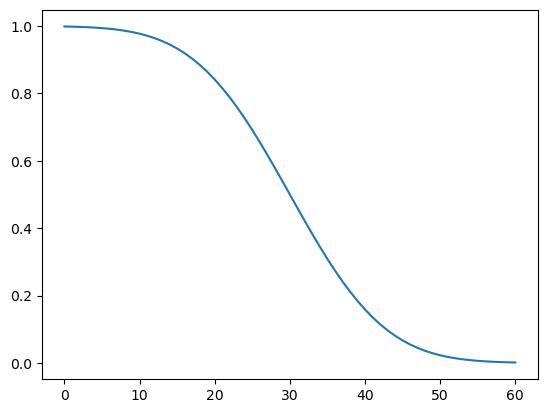

In [9]:
# Normal distribution
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy.stats.norm

norm_dist = norm(
    loc=30,  # shifts the center of the curve (mean point)
    scale=10,  # Controls the spread of the curve (standard deviation)
)
survival_curve = norm_dist.sf(timesteps)  # sf = survival function
plt.plot(survival_curve)
plt.show()

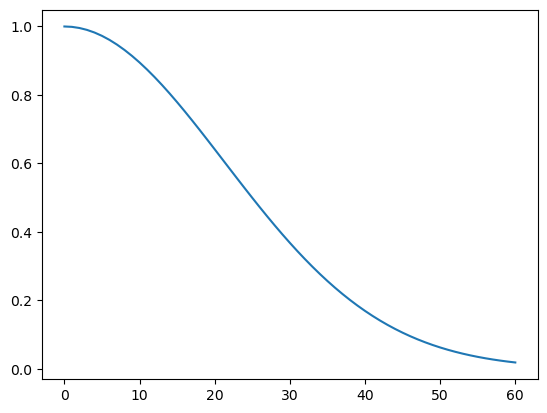

In [10]:
# Weibull distribution
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.weibull_min.html

weibull_dist = weibull_min(
    c=2,  # controls the shape of the curve (skewness)
    loc=0,  # shifts the curve along the x-axis (starting point)
    scale=30,  # Stretches or compresses the curve along the x-axis (spread)
)
survival_curve = weibull_dist.sf(timesteps)  # sf = survival function

plt.plot(survival_curve)
plt.show()

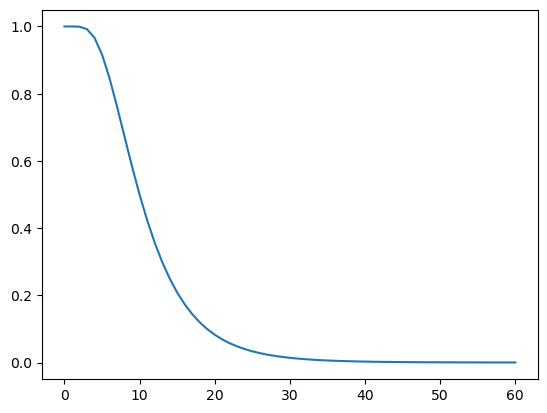

In [11]:
# Lognormal distribution
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html#scipy.stats.lognorm

lognorm_dist = lognorm(
    s=0.5,  # controls the shape of the curve (skewness)
    loc=0,  # shifts the curve along the x-axis (starting point)
    scale=10,  # controls the stretch of the distribution
)

survival_curve = lognorm_dist.sf(timesteps)  # sf = survival function

plt.plot(survival_curve)
plt.show()

# Create a survival curve matrix


In [12]:
# create survival curve matrix with placeholder zeros
survival_curve_matrix = pd.DataFrame(0, index=timesteps, columns=timesteps, dtype=float)

# populate the survival curve matrix with shifted curves, column by column using slices
for step in timesteps:
    # at each iteration, we stop 1 index earlier
    last_idx = step_max - step
    # we slice the survival curve up to that last index
    values = survival_curve[0:last_idx]
    # and we assign the sliced values to the sliced matrix:
    # --> rows: from step to step_max
    # --> columns: only the current step
    survival_curve_matrix.loc[step:step_max, step] = values

survival_curve_matrix

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.999998,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.999357,0.999998,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.991979,0.999357,0.999998,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.966568,0.991979,0.999357,0.999998,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.000285,0.000325,0.000372,0.000426,0.000488,0.000560,0.000643,0.000740,0.000853,0.000984,...,0.917171,0.966568,0.991979,0.999357,0.999998,1.000000,0.000000,0.000000,0.000000,0.0
57,0.000250,0.000285,0.000325,0.000372,0.000426,0.000488,0.000560,0.000643,0.000740,0.000853,...,0.846527,0.917171,0.966568,0.991979,0.999357,0.999998,1.000000,0.000000,0.000000,0.0
58,0.000219,0.000250,0.000285,0.000325,0.000372,0.000426,0.000488,0.000560,0.000643,0.000740,...,0.762185,0.846527,0.917171,0.966568,0.991979,0.999357,0.999998,1.000000,0.000000,0.0
59,0.000193,0.000219,0.000250,0.000285,0.000325,0.000372,0.000426,0.000488,0.000560,0.000643,...,0.672305,0.762185,0.846527,0.917171,0.966568,0.991979,0.999357,0.999998,1.000000,0.0


<Axes: >

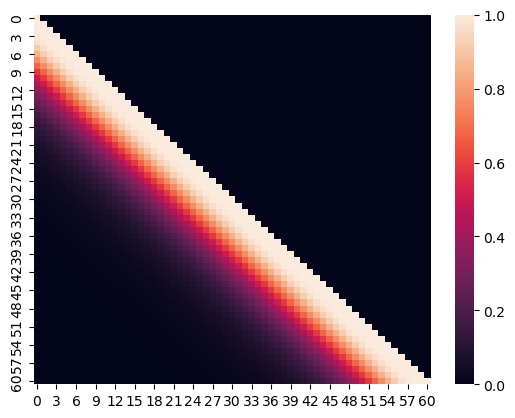

In [13]:
sns.heatmap(survival_curve_matrix, annot=False)

# Stock driven model


In [14]:
# This is our model input
stock = data["stock"]
stock

year
1990     20
1991     21
1992     30
1993     39
1994     45
       ... 
2046    724
2047    737
2048    750
2049    763
2050    776
Name: stock, Length: 61, dtype: int64

In [15]:
# create an empty inflow series that we will populate
inflows = pd.Series(0, index=stock.index, dtype=float)
inflows

year
1990    0.0
1991    0.0
1992    0.0
1993    0.0
1994    0.0
       ... 
2046    0.0
2047    0.0
2048    0.0
2049    0.0
2050    0.0
Length: 61, dtype: float64

In [16]:
# create survival matrix with placeholder zeros
cohort = pd.DataFrame(0, index=timesteps, columns=timesteps, dtype=float)

# iteratively calculate the inflows, and
# multiply the inflow with the shifted curves to get the cohorts' behavior over time
for time in timesteps:
    # calculate the difference between current stock and the sum of all prev inflows
    # but we don't forget to divide by survival_curve[0] (not always = 1)
    difference = stock.iloc[time] - cohort.loc[time, :].sum()
    inflows.iloc[time] = difference / survival_curve_matrix.loc[time, time]
    # the line below is the same as for flow driven models
    cohort.loc[:, time] = survival_curve_matrix.loc[:, time] * inflows.iloc[time]


# set index and columns to years instead of timesteps
cohort.index = years
cohort.columns = years

cohort

year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
year,,,,,,,,,,,,,,,,,,,,,
1990,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1991,19.999959,1.000041,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1992,19.987131,1.000039,9.012830,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1993,19.839574,0.999398,9.012812,9.148216,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1994,19.331352,0.992020,9.007031,9.148197,6.521401,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,0.005699,0.000325,0.003353,0.003896,0.003183,0.003408,0.001778,0.002581,0.043647,0.016499,...,58.099545,62.290668,65.018270,66.599921,67.741449,68.840371,0.000000,0.000000,0.000000,0.000000
2047,0.004997,0.000285,0.002933,0.003404,0.002777,0.002970,0.001547,0.002244,0.037889,0.014303,...,53.624469,59.107326,63.352722,66.108243,67.697999,68.840229,69.939151,0.000000,0.000000,0.000000
2048,0.004386,0.000250,0.002568,0.002977,0.002426,0.002592,0.001349,0.001953,0.032935,0.012417,...,48.281727,54.554626,60.115104,64.414774,67.198214,68.796074,69.939007,71.037930,0.000000,0.000000


<Axes: xlabel='year', ylabel='year'>

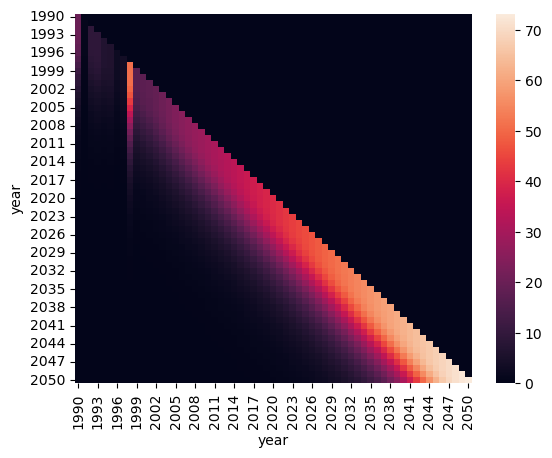

In [17]:
sns.heatmap(cohort, annot=False)

In [18]:
# calculate outflows and nas:
nas = np.diff(stock, prepend=0)  # prepending 0 assumes no initial stock
outflows = inflows - nas

# Visualize the results


In [39]:
data["stock"] = stock
data["outflow"] = outflows
data["nas"] = nas

data

,stock,inflow,outflow,nas
year,,,,
1990,20,20.000000,0.000000,20
1991,21,1.000041,0.000041,1
1992,30,9.012830,0.012830,9
1993,39,9.148216,0.148216,9
1994,45,6.521401,0.521401,6
...,...,...,...,...
2046,724,68.840371,55.840371,13
2047,737,69.939151,56.939151,13
2048,750,71.037930,58.037930,13


<Axes: xlabel='year'>

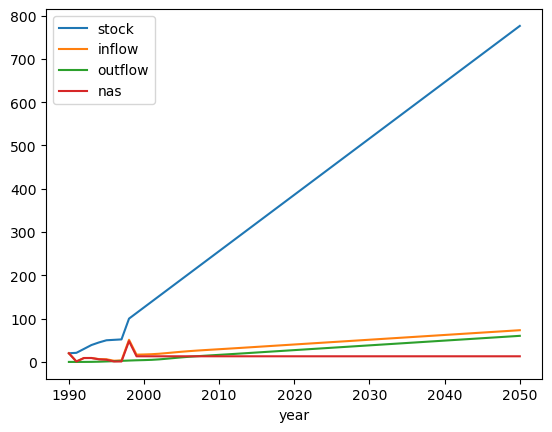

In [40]:
# Visualize on the same plot
data.plot()

<Axes: xlabel='year'>

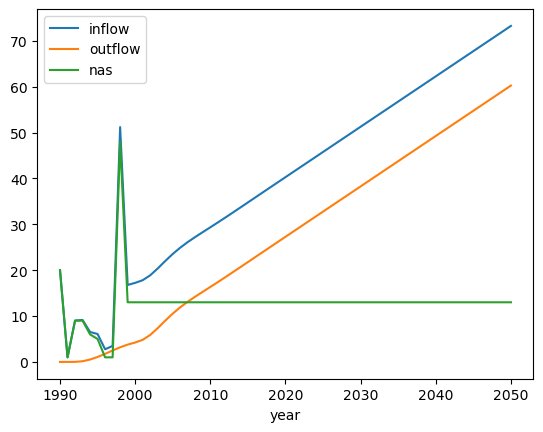

In [41]:
# Zooming in the flows and net addition to stock
data[["inflow", "outflow", "nas"]].plot()

<Axes: xlabel='year'>

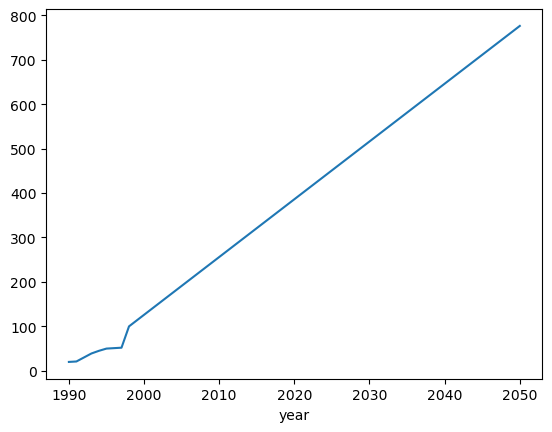

In [42]:
# Zooming in the stocks
data["stock"].plot()

# Export output data to Excel


In [ ]:
# Save the data to an Excel file
# (you may need to create the folder if it doesn't exist)
file_path = BASE_DIR / "data" / "processed" / "week_2_tutorial_myname.xlsx"
data.to_excel(file_path, sheet_name="stock_driven")

In [20]:
# But we also want to save the cohort data in the same excel file
# without overwriting the file.
# To do that, we open an Excel file in append mode ('a')
# https://pandas.pydata.org/docs/reference/api/pandas.ExcelWriter.html

with pd.ExcelWriter(file_path, mode="a") as writer:
    cohort.to_excel(writer, sheet_name="cohort_stock_driven")

# Going further


In [21]:
# Instead of a numpy array, we store the survival curve
# as a pandas Series with the appropriate index (= years)
sf = pd.Series(survival_curve, index=years)
sf

year
1990    1.000000
1991    0.999998
1992    0.999357
1993    0.991979
1994    0.966568
          ...   
2046    0.000285
2047    0.000250
2048    0.000219
2049    0.000193
2050    0.000169
Length: 61, dtype: float64

In [ ]:
# create survival curve matrix with placeholder zeros (same as before)
survival_curve_matrix2 = pd.DataFrame(0, index=years, columns=years, dtype=float)

# populate the survival curve matrix with shifted curves, column by column using slices
for counter, year in enumerate(years):
    # at each iteration, we stop 1 year earlier
    last_idx = end_year - counter
    # we slice the survival curve up to that last year
    values = sf.loc[:last_idx].values
    # and we assign the sliced values to the sliced matrix:
    # --> rows: from current year to the end year
    # --> columns: only the current year
    survival_curve_matrix2.loc[year:end_year, year] = values

# notice the names of the columns and rows
# are now years instead of timesteps
survival_curve_matrix2

year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
year,,,,,,,,,,,,,,,,,,,,,
1990,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1991,0.999998,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1992,0.999357,0.999998,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1993,0.991979,0.999357,0.999998,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1994,0.966568,0.991979,0.999357,0.999998,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,0.000285,0.000325,0.000372,0.000426,0.000488,0.000560,0.000643,0.000740,0.000853,0.000984,...,0.917171,0.966568,0.991979,0.999357,0.999998,1.000000,0.000000,0.000000,0.000000,0.0
2047,0.000250,0.000285,0.000325,0.000372,0.000426,0.000488,0.000560,0.000643,0.000740,0.000853,...,0.846527,0.917171,0.966568,0.991979,0.999357,0.999998,1.000000,0.000000,0.000000,0.0
2048,0.000219,0.000250,0.000285,0.000325,0.000372,0.000426,0.000488,0.000560,0.000643,0.000740,...,0.762185,0.846527,0.917171,0.966568,0.991979,0.999357,0.999998,1.000000,0.000000,0.0


<Axes: xlabel='year', ylabel='year'>

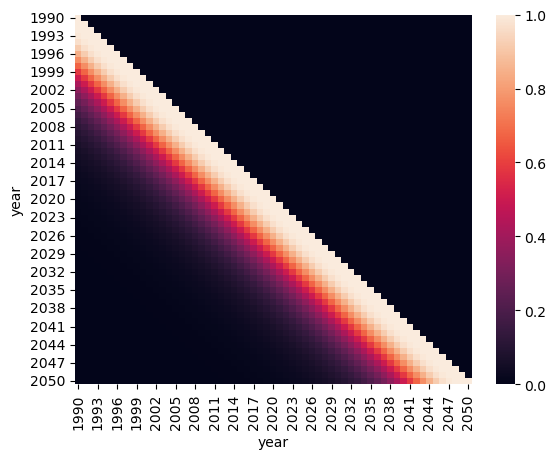

In [ ]:
# notice the names of the columns and rows
# are now years instead of timesteps
sns.heatmap(survival_curve_matrix2, annot=False)

There are different types of matrix multiplications:

- the **dot product** (using the `np.dot()` function or the `@` operator)?
- the **element-wise matrix multiplication** (`np.multiply()` function or `*` operator)

The **dot product** does the following:

$$
\begin{bmatrix}
a_{11} & a_{12} & a_{13} \\
a_{21} & a_{22} & a_{23} \\
a_{31} & a_{32} & a_{33} \\
\end{bmatrix}
\cdot
\begin{bmatrix}
f_1 \\
f_2 \\
f_3
\end{bmatrix}
=
\begin{bmatrix}
a_{11} f_1 + a_{12} f_2  + a_{13} f_3  \\
a_{21} f_1 + a_{22} f_2  + a_{23} f_3  \\
a_{31} f_1 + a_{32} f_2  + a_{33} f_3  \\
\end{bmatrix}
$$

Now assuming that

- the matrix $\mathbf{A}$ represents the `survival_curve_matrix`
- and the vector $\mathbf{f}$ represents the `inflows`,

we get:

$$
\begin{bmatrix}
a_{1} & 0 & 0 \\
a_{2} & a_{1} & 0 \\
a_{3} & a_{2} & a_{1} \\
\end{bmatrix}
\cdot
\begin{bmatrix}
f_1 \\
f_2 \\
f_3
\end{bmatrix}
=
\begin{bmatrix}
a_{1} f_1 \\
a_{2} f_1 + a_{1} f_2  \\
a_{3} f_1 + a_{2} f_2  + a_{1} f_3  \\
\end{bmatrix}
$$

You may recognize the `stock` vector $\mathbf{s}$ as the result

In other words, we have the following system of linear equations:

$$
\begin{align}
\mathbf{A} \cdot \mathbf{f} &= \mathbf{s} \\
\mathbf{f} &= \mathbf{A}^{-1} \cdot \mathbf{s}
\end{align}
$$

And the `scipy.linalg.solve()` can help us solve it

$$\mathbf{f} = \text{solve}(\mathbf{A}, \mathbf{s})$$


In [ ]:
# the linear algebra library in scipy allows us to solve this
# but it returns a numpy array, so we convert it into a Pandas Series
inflows2 = solve(survival_curve_matrix2, stock)
inflows2 = pd.Series(inflows2, index=years)
inflows2

year
1990    20.000000
1991     1.000041
1992     9.012830
1993     9.148216
1994     6.521401
          ...    
2046    68.840371
2047    69.939151
2048    71.037930
2049    72.136708
2050    73.235484
Length: 61, dtype: float64

In [38]:
# Check that they are indeed the same
# always use np.allclose() instead of == to compare floats
np.allclose(inflows2, inflows)

True

# More information and tips


- [Statistical functions in scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html)
- the `enumerate()` function on [W3school](https://www.w3schools.com/python/ref_func_enumerate.asp) or [Programiz](https://www.programiz.com/python-programming/methods/built-in/enumerate)
- [Pandas excel writer](https://pandas.pydata.org/docs/reference/api/pandas.ExcelWriter.html)
- [Scipy Solver](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve.html) from the [Linear Algebra library](https://docs.scipy.org/doc/scipy/reference/linalg.html)
